In [1]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import data_extraction
import ARIMA
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
def ANN_train(X_train, y_train, hidden_layers, alpha=1e-5, random_state=1):
    '''
    INPUT:
    timeseries: TYPE: DataFrame. Contains column named 'residual'
    q: TYPE: Integer. Decides how many historical values to consider
    hidden_layers: TYPE: Tuple of integers. The number on the i'th position decides number of nodes in hidden layer i

    OUTPUT:
    Returns trained model: TYPE: MLPRegressor
    '''
    model = MLPRegressor(solver="adam", 
                         alpha=alpha, 
                         hidden_layer_sizes=hidden_layers, 
                         random_state=random_state, 
                         max_iter=20000,
                         tol=1e-4) #default tolerance
    model.fit(X_train, y_train)
    return model

In [9]:
past_days = 40
nRowsRead = None
grid_number = 1
hidden_layers = (20,10)

In [4]:
loss_train_series = data_extraction.get_timeseries("train", nRowsRead, 'loss', grid_number)
loss_test_series = data_extraction.get_timeseries("test", nRowsRead, 'loss', grid_number)

load_train_series = data_extraction.get_timeseries("train", nRowsRead, 'load', grid_number)
load_test_series = data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number)


df = loss_test_series.append(loss_test_series).to_frame()
df['load'] = load_train_series.append(load_test_series).to_frame()

df


,grid1-loss,load
2019-12-01 00:00:00,21.55210,407.67600
2019-12-01 01:00:00,20.71190,397.96600
2019-12-01 02:00:00,20.27340,392.90400
2019-12-01 03:00:00,20.25370,392.72600
2019-12-01 04:00:00,20.40550,394.47800
...,...,...
2020-05-30 19:00:00,8.55980,228.64142
2020-05-30 20:00:00,6.95209,224.54790
2020-05-30 21:00:00,8.11558,223.84220
2020-05-30 23:00:00,7.26431,208.35270


In [5]:
# legge til time og måned
indices = df.index
hours = [0 for i in range(len(indices))]
months = [0 for i in range(len(indices))]
for i in range(len(indices)):
    hours[i] = datetime.strptime(indices[i], "%Y-%m-%d %H:%M:%S").hour
    months[i] = datetime.strptime(indices[i], "%Y-%m-%d %H:%M:%S").month //3

df['hours'] = hours
df['months'] = months

df

,grid1-loss,load,hours,months
2019-12-01 00:00:00,21.55210,407.67600,0,4
2019-12-01 01:00:00,20.71190,397.96600,1,4
2019-12-01 02:00:00,20.27340,392.90400,2,4
2019-12-01 03:00:00,20.25370,392.72600,3,4
2019-12-01 04:00:00,20.40550,394.47800,4,4
...,...,...,...,...
2020-05-30 19:00:00,8.55980,228.64142,19,1
2020-05-30 20:00:00,6.95209,224.54790,20,1
2020-05-30 21:00:00,8.11558,223.84220,21,1
2020-05-30 23:00:00,7.26431,208.35270,23,1


In [6]:
from scipy.signal import argrelextrema
gridloss_corr_gridloss_shifted = []
for i in range(24*7*24):
    df['grid1-loss_shifted'] = df['grid1-loss'].shift(i)
    gridloss_corr_gridloss_shifted.append(df.corr(method='pearson')['grid1-loss_shifted']['grid1-loss'])

correlation = pd.DataFrame(index = [i for i in range(24*7*24)])

In [7]:

gridloss_corr_load_shifted = []
for i in range(24*7*24):
    df['load_shifted'] = df['load'].shift(i)
    gridloss_corr_load_shifted.append(df.corr(method='pearson')['load_shifted']['grid1-loss'])


In [8]:
print("Grid loss correlation to hour of the day:", df.corr(method='pearson')['grid1-loss']['hours'])
print("Grid loss correlation to month of the year:", df.corr(method='pearson')['grid1-loss']['months'])

Grid loss correlation to hour of the day: 0.21495248868959016
Grid loss correlation to month of the year: 0.07538364865159035


In [9]:
correlation['corrs_loss'] = gridloss_corr_gridloss_shifted
correlation['corrs_load'] = gridloss_corr_load_shifted

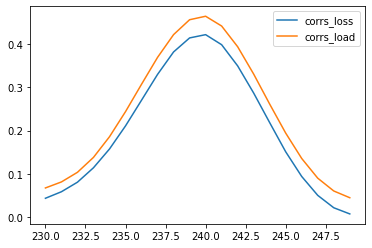

In [10]:
correlation.iloc[230:250].plot()

In [7]:
def data_ANN(past_days):
    # input values
    # past_days is the number of past days of the grid_loss that the ANN will use
    loss_train_series = data_extraction.get_timeseries("train", nRowsRead, 'loss', grid_number)
    loss_test_series = data_extraction.get_timeseries("test", nRowsRead, 'loss', grid_number)
    load_train_series = data_extraction.get_timeseries("train", nRowsRead, 'load', grid_number)
    load_test_series = data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number)
    
    loss_series = loss_train_series.append(loss_test_series)
    load_series = load_train_series.append(load_test_series)
    
    X = []
    y = []
    
    
    for i in range(len(loss_series) - past_days*24):
        X.append(loss_series[i:i+past_days*24:24].values + load_series[i:i+past_days*24:24].values)
        y.append(loss_series[i + past_days*24])
    
    return X, y


In [10]:
X,y = data_ANN(past_days)

In [13]:
train_size = len(data_extraction.get_timeseries("train", nRowsRead, 'loss', grid_number)) - past_days*24
X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

In [12]:
model = ANN_train(X_train, y_train, hidden_layers)

NameError: name 'ANN_train' is not defined

In [15]:
def ANN_pred(model, X_test):
    X_test = X_test.copy()
    y_test = []
    for X_test_el in X_test:
        val = model.predict(X_test_el.reshape(1,-1))

        y_test.append(val[0])
    return y_test



In [16]:
y_pred = ANN_pred(model, X_test)

In [17]:
new_df = data_extraction.get_timeseries("test", nRowsRead, 'loss', grid_number).to_frame()

new_df

,grid1-loss
2019-12-01 00:00:00,21.55210
2019-12-01 01:00:00,20.71190
2019-12-01 02:00:00,20.27340
2019-12-01 03:00:00,20.25370
2019-12-01 04:00:00,20.40550
...,...
2020-05-30 19:00:00,8.55980
2020-05-30 20:00:00,6.95209
2020-05-30 21:00:00,8.11558
2020-05-30 23:00:00,7.26431


In [18]:
new_df["pred"] = y_pred
new_df["diff"] = new_df["grid1-loss"]-new_df["pred"]

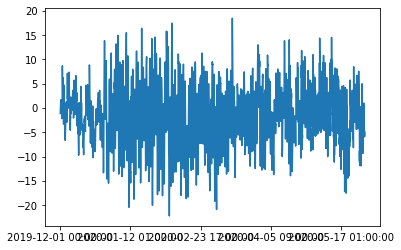

In [19]:
new_df["diff"].plot()

In [20]:
new_df['ann_sum_error'] = abs(new_df['grid1-loss'] - new_df['pred'])
new_df['ann_cumsum'] = new_df['ann_sum_error'].cumsum()
new_df['ann_cumsum'][-1]

22556.40085557993

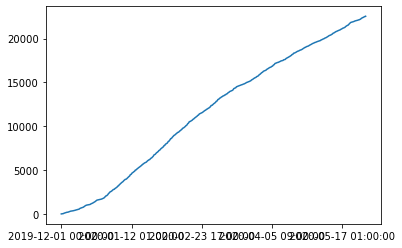

In [21]:
new_df['ann_cumsum'].plot()

In [22]:
new_df.to_pickle('ANN_forecast.pkl')

In [2]:
model = MLPRegressor(solver="adam", 
                         alpha=1e-5, 
                         random_state=1, 
                         max_iter=20000,
                         tol=1e-4)

In [3]:
model.get_params().keys()

dict_keys(['activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_fun', 'max_iter', 'momentum', 'n_iter_no_change', 'nesterovs_momentum', 'power_t', 'random_state', 'shuffle', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [4]:
parameters = {'solver': ['adam'], 'hidden_layer_sizes' : [(i,i) for i in range(2,5,2)]}

In [5]:
gsCV = GridSearchCV(model , parameters)

In [14]:
gsCV.fit(X_train, y_train)

GridSearchCV(estimator=MLPRegressor(alpha=1e-05, max_iter=20000,
                                    random_state=1),
             param_grid={'hidden_layer_sizes': [(2, 2), (4, 4)],
                         'solver': ['adam']})

In [16]:
sorted(gsCV.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_hidden_layer_sizes',
 'param_solver',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [21]:
gsCV.best_params_

{'hidden_layer_sizes': (4, 4), 'solver': 'adam'}